In [35]:

import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

!pip install -q onnxruntime
import onnxruntime as ort

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# path
TEST_IMAGE_PATH        = "/content/photo_2025-12-05_02-12-20.jpg"
RETINAFACE_ONNX_PATH   = "/content/retinaface_mobilenet0.25.onnx"
EMO_MODEL_PATH         = "/content/raf_stage1plus_best2.pth"

EMO_CLASS_NAMES = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']


cfg = {
    "min_sizes": [[16, 32], [64, 128], [256, 512]],
    "steps": [8, 16, 32],
    "variance": [0.1, 0.2]
}

def generate_priors(image_shape, cfg):
    """
    生成 RetinaFace 的先验框 (cx, cy, w, h)，归一化到 [0,1]
    image_shape: (H, W)
    """
    image_h, image_w = image_shape
    priors = []
    for k, step in enumerate(cfg["steps"]):
        feat_h = int(math.ceil(image_h / step))
        feat_w = int(math.ceil(image_w / step))
        min_sizes = cfg["min_sizes"][k]
        for i in range(feat_h):
            for j in range(feat_w):
                cy = (i + 0.5) * step / image_h
                cx = (j + 0.5) * step / image_w
                for min_size in min_sizes:
                    w = min_size / image_w
                    h = min_size / image_h
                    priors.append([cx, cy, w, h])
    priors = np.array(priors, dtype=np.float32)
    return priors

def decode_boxes(loc, priors, variances):
    """
    loc: [num_priors, 4]
    priors: [num_priors, 4]  (cx, cy, w, h)
    return: [num_priors, 4] (x1, y1, x2, y2) 归一化坐标
    """
    boxes = np.concatenate((
        priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:],
        priors[:, 2:] * np.exp(loc[:, 2:] * variances[1])
    ), axis=1)  # [cx, cy, w, h]

    # cxcywh -> xyxy
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    return boxes

def decode_landmarks(landms, priors, variances):
    """
    landms: [num_priors, 10]
    priors: [num_priors, 4]
    return: [num_priors, 10]
    """
    out = np.zeros_like(landms)
    for k in range(5):
        out[:, 2 * k:2 * k + 2] = priors[:, :2] + \
            landms[:, 2 * k:2 * k + 2] * variances[0] * priors[:, 2:]
    return out

def nms_numpy(dets, thresh=0.4):
    """
    dets: [N, 5] -> x1, y1, x2, y2, score
    """
    if dets.size == 0:
        return []

    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]
    return keep

def align_face(img, landmarks, output_size=224):
    eye_left, eye_right, nose, mouth_left, mouth_right = landmarks

    eye_center = (eye_left + eye_right) * 0.5
    dy = eye_right[1] - eye_left[1]
    dx = eye_right[0] - eye_left[0]
    angle = math.degrees(math.atan2(dy, dx))

    eye_dist = np.linalg.norm(eye_right - eye_left)
    if eye_dist < 1e-6:
        eye_dist = 1.0

    desired_left_eye  = (0.35, 0.35)
    desired_right_eye = (0.65, 0.35)

    desired_eye_dist = (desired_right_eye[0] - desired_left_eye[0]) * output_size
    scale = desired_eye_dist / eye_dist


    desired_center_x = (desired_left_eye[0] + desired_right_eye[0]) / 2 * output_size
    desired_center_y = desired_left_eye[1] * output_size
    M = cv2.getRotationMatrix2D((eye_center[0], eye_center[1]), angle, scale)

    M[0, 2] += (desired_center_x - eye_center[0])
    M[1, 2] += (desired_center_y - eye_center[1])

    aligned = cv2.warpAffine(
        img, M, (output_size, output_size),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_REPLICATE
    )
    return aligned



def preprocess_image(image_path, target_size, nchw_format):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"image {image_path} not found")

    orig_h, orig_w = img.shape[:2]
    target_h, target_w = target_size

    scale = min(target_w / orig_w, target_h / orig_h)
    new_w = int(orig_w * scale)
    new_h = int(orig_h * scale)
    resized = cv2.resize(img, (new_w, new_h))

    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    canvas[:new_h, :new_w, :] = resized

    img_float = canvas.astype(np.float32)
    img_float -= np.array([104, 117, 123], dtype=np.float32)

    if nchw_format:
        img_float = np.transpose(img_float, (2, 0, 1))  # HWC -> CHW
    img_input = np.expand_dims(img_float, axis=0)

    return img_input, scale, (orig_h, orig_w), img

print("RetinaFace helper functions ready.")

class RAFStage1Plus(nn.Module):
    def __init__(self, num_classes=7, embed_dim=128, pretrained_backbone=True):
        super().__init__()
        if pretrained_backbone:
            base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        else:
            base = models.resnet18(weights=None)

        in_features = base.fc.in_features
        base.fc = nn.Identity()

        self.encoder_backbone = base
        self.embedding = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, embed_dim)
        )
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x, return_embedding=False):
        feat = self.encoder_backbone(x)
        emb = self.embedding(feat)
        emb = F.normalize(emb, p=2, dim=1)
        if return_embedding:
            return self.classifier(emb), emb
        else:
            return self.classifier(emb)

face_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

print("RAFStage1Plus model class & transforms ready.")


Using device: cuda
RetinaFace helper functions ready.
RAFStage1Plus model class & transforms ready.


Processing image: /content/photo_2025-12-05_02-12-20.jpg
Loading RetinaFace ONNX from: /content/retinaface_mobilenet0.25.onnx
ONNX providers in use: ['CPUExecutionProvider']
Detector input name: RetinaFace::input_0
Detector input shape: ['RetinaFace::input_0_dynamic_axes_1', 608, 640, 3]
Model input size: 608x640, format: NHWC
Priors generated: 15960
Preprocessed shape: (1, 608, 640, 3), scale: 0.475, original size: (1280, 960)
Running RetinaFace inference...
Total predictions: 15960
Score stats: max=0.9943, min=0.0003, mean=0.0040
After NMS, faces: 2
Saved image with detections to: /content/photo_2025-12-05_02-12-20_with_detections.jpg
Saved 2 aligned faces to: /content/photo_2025-12-05_02-12-20_aligned_faces


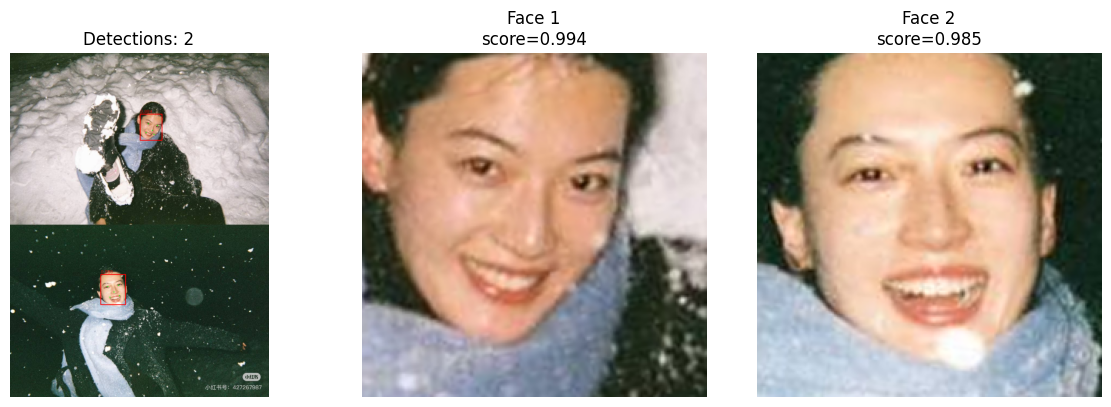

Face detection & alignment finished. Ready for expression recognition.


In [36]:

# Face Detection + Alignment (ONNX)



if not os.path.exists(TEST_IMAGE_PATH):
    raise FileNotFoundError(f"Test image not found at {TEST_IMAGE_PATH}")
print(f"Processing image: {TEST_IMAGE_PATH}")

if not os.path.exists(RETINAFACE_ONNX_PATH):
    raise FileNotFoundError(f"RetinaFace model not found at {RETINAFACE_ONNX_PATH}")
print(f"Loading RetinaFace ONNX from: {RETINAFACE_ONNX_PATH}")

# ONNX Runtime Session
providers = ["CUDAExecutionProvider", "CPUExecutionProvider"]
try:
    det_session = ort.InferenceSession(RETINAFACE_ONNX_PATH, providers=providers)
except Exception as e:
    print(f"Error creating session with CUDA, fallback to default. Error: {e}")
    det_session = ort.InferenceSession(RETINAFACE_ONNX_PATH)

prov = det_session.get_providers()
print(f"ONNX providers in use: {prov}")

input_name = det_session.get_inputs()[0].name
input_shape = det_session.get_inputs()[0].shape
print(f"Detector input name: {input_name}")
print(f"Detector input shape: {input_shape}")

#  NCHW / NHWC
NCHW = False
if len(input_shape) == 4:
    if input_shape[1] == 3:
        NCHW = True
        INPUT_H = int(input_shape[2])
        INPUT_W = int(input_shape[3])
    elif input_shape[-1] == 3:
        NCHW = False
        INPUT_H = int(input_shape[1])
        INPUT_W = int(input_shape[2])
    else:
        INPUT_H, INPUT_W = 640, 640
        print("Warning: unexpected input shape, assume 640x640.")
else:
    INPUT_H, INPUT_W = 640, 640
    print("Warning: unexpected input rank, assume 640x640.")

TARGET_SIZE = (INPUT_H, INPUT_W)
print(f"Model input size: {INPUT_H}x{INPUT_W}, format: {'NCHW' if NCHW else 'NHWC'}")


priors = generate_priors((INPUT_H, INPUT_W), cfg)
print(f"Priors generated: {priors.shape[0]}")


img_input, scale, orig_size, original_img = preprocess_image(TEST_IMAGE_PATH, TARGET_SIZE, NCHW)
img_input = img_input.astype(np.float32)
print(f"Preprocessed shape: {img_input.shape}, scale: {scale}, original size: {orig_size}")


print("Running RetinaFace inference...")
loc, conf, landms = det_session.run(None, {input_name: img_input})


loc    = loc.reshape(-1, 4)
conf   = conf.reshape(-1, 2)
landms = landms.reshape(-1, 10)

num = min(loc.shape[0], conf.shape[0], landms.shape[0], priors.shape[0])
loc        = loc[:num]
conf       = conf[:num]
landms     = landms[:num]
priors_use = priors[:num]


conf_exp = np.exp(conf - np.max(conf, axis=-1, keepdims=True))
conf_softmax = conf_exp / np.sum(conf_exp, axis=-1, keepdims=True)
scores = conf_softmax[:, 1]

print(f"Total predictions: {num}")
print(f"Score stats: max={scores.max():.4f}, min={scores.min():.4f}, mean={scores.mean():.4f}")


conf_thresh = 0.6
keep = scores > conf_thresh

if not np.any(keep):
    print("No faces with score > 0.6, using adaptive threshold...")
    adaptive_thresh = max(0.02, float(scores.max()) * 0.5)
    conf_thresh = adaptive_thresh
    print(f"Adaptive threshold: {conf_thresh:.4f}")
    keep = scores > conf_thresh

if not np.any(keep):
    print("Still no faces with adaptive threshold, keep top-1 candidate as face.")
    keep = np.zeros_like(scores, dtype=bool)
    keep[np.argmax(scores)] = True

loc_keep    = loc[keep]
scores_keep = scores[keep]
landms_keep = landms[keep]
priors_keep = priors_use[keep]

boxes = decode_boxes(loc_keep, priors_keep, cfg["variance"])
landms_dec = decode_landmarks(landms_keep, priors_keep, cfg["variance"])


boxes[:, 0::2] *= INPUT_W
boxes[:, 1::2] *= INPUT_H
landms_dec[:, 0::2] *= INPUT_W
landms_dec[:, 1::2] *= INPUT_H

boxes[:, 0::2] /= scale
boxes[:, 1::2] /= scale
landms_dec[:, 0::2] /= scale
landms_dec[:, 1::2] /= scale

orig_h, orig_w = orig_size
boxes[:, 0::2] = np.clip(boxes[:, 0::2], 0, orig_w - 1)
boxes[:, 1::2] = np.clip(boxes[:, 1::2], 0, orig_h - 1)

dets_for_nms = np.hstack([boxes, scores_keep[:, None]]).astype(np.float32)
keep_indices = nms_numpy(dets_for_nms, thresh=0.4)

boxes        = boxes[keep_indices]
scores_final = scores_keep[keep_indices]
landms_dec   = landms_dec[keep_indices]

print(f"After NMS, faces: {len(boxes)}")

original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
img_with_boxes = original_img_rgb.copy()
aligned_faces = []

for j in range(boxes.shape[0]):
    x1, y1, x2, y2 = boxes[j].astype(int)
    s = float(scores_final[j])
    lm = landms_dec[j].reshape(5, 2)

    cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(img_with_boxes, f"{s:.3f}", (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    for k in range(5):
        cx, cy = int(lm[k, 0]), int(lm[k, 1])
        cv2.circle(img_with_boxes, (cx, cy), 2, (0, 255, 0), -1)

    aligned = align_face(original_img, lm, output_size=224)
    aligned_rgb = cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB)
    aligned_faces.append(aligned_rgb)


img_dir = os.path.dirname(TEST_IMAGE_PATH)
base_name = os.path.splitext(os.path.basename(TEST_IMAGE_PATH))[0]

out_det_path = os.path.join(img_dir, f"{base_name}_with_detections.jpg")
cv2.imwrite(out_det_path, cv2.cvtColor(img_with_boxes, cv2.COLOR_RGB2BGR))
print(f"Saved image with detections to: {out_det_path}")

aligned_dir = os.path.join(img_dir, f"{base_name}_aligned_faces")
os.makedirs(aligned_dir, exist_ok=True)

face_paths = []
for idx, face_rgb in enumerate(aligned_faces):
    save_path = os.path.join(aligned_dir, f"face_{idx:02d}.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(face_rgb, cv2.COLOR_RGB2BGR))
    face_paths.append(save_path)

print(f"Saved {len(face_paths)} aligned faces to: {aligned_dir}")

global detected_faces_info
detected_faces_info = {
    "paths": face_paths,
    "count": len(face_paths),
    "output_dir": aligned_dir,
    "scores": scores_final.tolist(),
    "boxes": boxes.tolist()
}


plt.figure(figsize=(4 * (len(face_paths) + 1), 4))

plt.subplot(1, len(face_paths) + 1, 1)
plt.imshow(img_with_boxes)
plt.title(f"Detections: {len(face_paths)}")
plt.axis("off")

for i, face_img in enumerate(aligned_faces):
    plt.subplot(1, len(face_paths) + 1, i + 2)
    plt.imshow(face_img)
    plt.title(f"Face {i+1}\nscore={scores_final[i]:.3f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

print("Face detection & alignment finished. Ready for expression recognition.")


Found 2 aligned faces for expression recognition.
Loading expression model from: /content/raf_stage1plus_best2.pth
Expression model loaded.


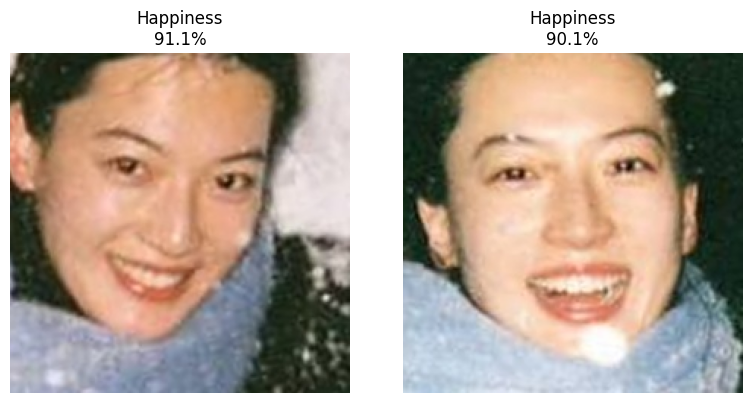


Expression recognition results:
face_00.jpg -> Happiness (91.09%)
face_01.jpg -> Happiness (90.07%)


In [37]:

# Expression Recognition


if "detected_faces_info" not in globals() or detected_faces_info["count"] == 0:
    print("No detected faces found in 'detected_faces_info'. "
          "Please run Cell 2 successfully first.")
else:
    face_paths = detected_faces_info["paths"]
    print(f"Found {len(face_paths)} aligned faces for expression recognition.")

    emo_ckpt_path = Path(EMO_MODEL_PATH)
    if not emo_ckpt_path.exists():
        raise FileNotFoundError(f"Expression model not found at: {emo_ckpt_path}")

    print(f"Loading expression model from: {emo_ckpt_path}")
    num_classes = len(EMO_CLASS_NAMES)

    emo_model = RAFStage1Plus(
        num_classes=num_classes,
        embed_dim=128,
        pretrained_backbone=True
    ).to(device)

    ckpt = torch.load(emo_ckpt_path, map_location=device)
    if "model_state_dict" in ckpt:
        emo_model.load_state_dict(ckpt["model_state_dict"])
    elif "model_state" in ckpt:
        emo_model.load_state_dict(ckpt["model_state"])
    elif "state_dict" in ckpt:
        emo_model.load_state_dict(ckpt["state_dict"])
    else:
        emo_model.load_state_dict(ckpt)
    emo_model.eval()
    print("Expression model loaded.")

    results = []
    plt.figure(figsize=(4 * len(face_paths), 4))

    for i, fpath in enumerate(face_paths):
        img = Image.open(fpath).convert("RGB")
        x = face_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = emo_model(x)
            probs = F.softmax(logits, dim=1)
            prob_val, pred_idx = torch.max(probs, dim=1)

        pred_idx = pred_idx.item()
        prob_val = prob_val.item()
        pred_label = EMO_CLASS_NAMES[pred_idx]

        results.append((fpath, pred_label, prob_val))

        plt.subplot(1, len(face_paths), i + 1)
        plt.imshow(img)
        plt.title(f"{pred_label}\n{prob_val*100:.1f}%", fontsize=12)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    print("\nExpression recognition results:")
    for fpath, label, prob in results:
        print(f"{os.path.basename(fpath)} -> {label} ({prob*100:.2f}%)")
